In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

from edunets import functions
from edunets.nn import Linear
from edunets.tensor import Tensor

(<matplotlib.image.AxesImage at 0x7f5a3643ca60>, 5)

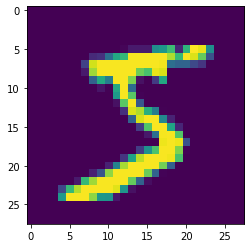

In [3]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.imshow(X_train[0]), Y_train[0]

In [28]:
class EduNet1:
    def __init__(self):
        self.l1 = Tensor.uniform(784, 128, requires_grad=True, label="L1")
        self.l2 = Tensor.uniform(128, 10, requires_grad=True, label="L2")

    def __call__(self, x):
        x = x @ self.l1
        x = x.relu()
        x = x @ self.l2
        return x.softmax(axis=1)

# Mean Square Error
def MSELOSS(out, Y):
    n = Y.shape[0]
    return (1/n)*((out - Y)**2).sum()

# Stochastic gradient descent
class SGD:
    def __init__(self, params, lr=10):
        self.lr = lr
        self.params = params

    def step(self):
        for t in self.params:
            t.assign(t.data - t.grad * self.lr)

    def zero_grad(self):
        for param in self.params:
            param.grad = None

tensor([[-0.11021154,  0.99688464, -0.969904  , ..., -0.30460057,
         0.45379236, -0.6622586 ],
       [-0.3699496 ,  0.32321274,  0.15278886, ...,  0.22908485,
         0.9597294 , -0.04384497],
       [-0.11438948,  0.910471  , -0.1135212 , ..., -0.4560567 ,
         0.5449083 , -0.19595774],
       ...,
       [-0.9121137 , -0.97965175, -0.00682493, ...,  0.29459357,
        -0.9029683 , -0.72302353],
       [ 0.7011026 , -0.02890131,  0.06016308, ...,  0.05859099,
        -0.6254442 , -0.41424748],
       [-0.3891716 , -0.6621184 ,  0.9233246 , ..., -0.06143459,
         0.8427867 , -0.81931794]], dtype=float32, requires_grad=True)


loss 1.91 accuracy 0.00: 100%|██████████| 100/100 [00:00<00:00, 131.99it/s]


tensor([[-0.11021154,  0.99688464, -0.969904  , ..., -0.30460057,
         0.45379236, -0.6622586 ],
       [-0.3699496 ,  0.32321274,  0.15278886, ...,  0.22908485,
         0.9597294 , -0.04384497],
       [-0.11438948,  0.910471  , -0.1135212 , ..., -0.4560567 ,
         0.5449083 , -0.19595774],
       ...,
       [-0.9121137 , -0.97965175, -0.00682493, ...,  0.29459357,
        -0.9029683 , -0.72302353],
       [ 0.7011026 , -0.02890131,  0.06016308, ...,  0.05859099,
        -0.6254442 , -0.41424748],
       [-0.3891716 , -0.6621184 ,  0.9233246 , ..., -0.06143459,
         0.8427867 , -0.81931794]], dtype=float32, requires_grad=True)


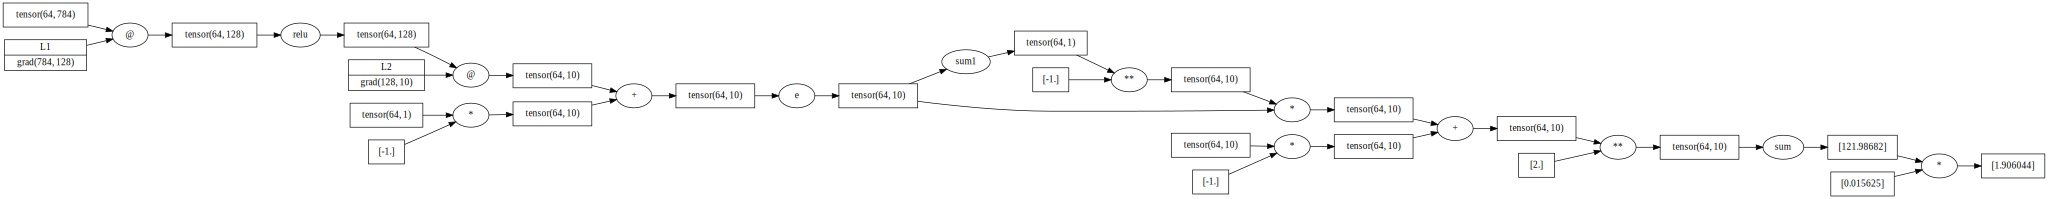

In [31]:
model = EduNet1()

optim = SGD([model.l1, model.l2], lr=0.001)
batch_size = 64
epochs = 100
losses, accuracies = [], []

print(model.l1)

for i in (t := trange(epochs)):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))

    X = Tensor(X_train[samp].reshape((-1, 28*28)))
    Y = functions.one_hot(Tensor(Y_train[samp]))

    out = model(X)
    
    cat = functions.argmax(out, axis=1)
    
    accuracy = (cat == Y).mean()

    loss = MSELOSS(out, Y)
    
    optim.zero_grad()
    
    loss.backward()
    
    optim.step()
    
    losses.append(loss.data)
    
    accuracies.append(accuracy.data)
    
    t.set_description("loss %.2f accuracy %.2f" % (loss.data, accuracy.data))

print(model.l1)
loss.graph


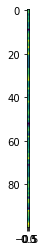

In [32]:
plt.imshow(losses)